In [6]:
import os

import ssl
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import SVG, Image
from skimage.feature import hog
from skimage import color
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import (Dense, Conv2D, InputLayer, 
                          GlobalAveragePooling2D, Activation,
                          Dropout, MaxPooling2D, Flatten)
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [7]:
ssl._create_default_https_context = ssl._create_unverified_context

# Скачаем данные и посмотрим на них

Мы будем использовать cifar10, подробно прочитать про него можно тут: https://www.cs.toronto.edu/~kriz/cifar.html или тут: https://keras.io/datasets/.

In [8]:
filenames = ('x_train.npy', 'x_test.npy', 'y_train.npy', 'y_test.npy')
if all([os.path.exists('./cifar10/' + filename) for filename in filenames]):
    x_train = np.load('cifar10/x_train.npy')
    x_test = np.load('cifar10/x_test.npy')
    y_train = np.load('cifar10/y_train.npy')
    y_test = np.load('cifar10/y_test.npy')
else:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    str_2_var = {'x_train': x_train,
             'x_test': x_test,
             'y_train': y_train,
             'y_test': y_test}
    
    if not os.path.exists('cifar10/'):
        os.mkdir('cifar_10/')

    for var_str, var_name in str_2_var.items():
        np.save('cifar10_' + var_str + '.npy', var_name)

In [9]:
class_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
               5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

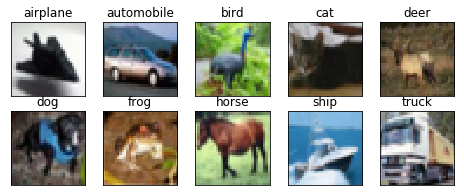

In [10]:
fig = plt.figure(figsize=(8,3))

for i in range(len(class_names)):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    idx = np.where(y_train[:]==i)[0][0]
    image = x_train[idx]
    plt.imshow(image)

plt.show()

# Классическое компьютерное зрение

### Histogram of Oriented Gradients (HoG)

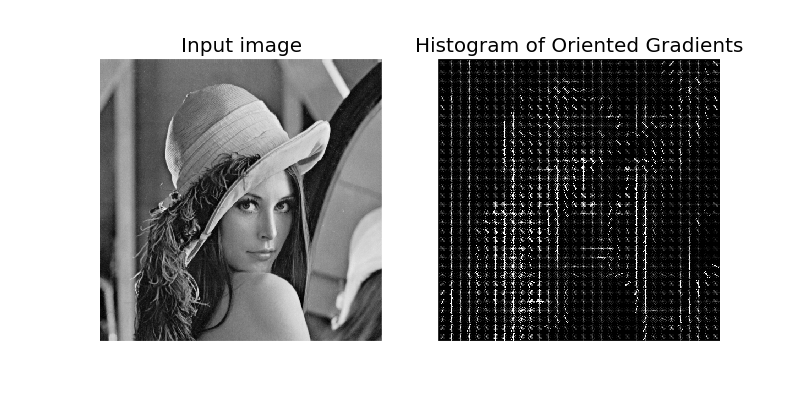

In [11]:
Image('pics/hog.png', width=750)

Histogram of Oriented Gradients - способ извлечения признаков из изображений. Главная идея - найти направления граней на изображении по их интенсивности, а затем использовать их частоту (преобразованную каким-либо хитрым способом) как признаки изображения. Подробнее про HoG можно почитать тут: https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients.

In [12]:
print('HoG features for train set')
x_train_hog = []
for i in tqdm.tqdm_notebook(range(len(x_train))):
    img_hog = hog(image=x_train[i],
                  pixels_per_cell=(8, 8),
                  block_norm='L2-Hys')
    x_train_hog.append(img_hog)
x_train_hog = np.array(x_train_hog)
    
print('HoG features for test set')
x_test_hog = []
for i in tqdm.tqdm_notebook(range(len(x_test))):
    img_hog = hog(image=x_test[i],
                  pixels_per_cell=(8, 8),
                  block_norm='L2-Hys')
    x_test_hog.append(img_hog)
x_test_hog = np.array(x_test_hog)

HoG features for train set



HoG features for test set


### Обучим логистическуб регрессию на HoG признаках

In [23]:
model_logreg_hog = LogisticRegression(solver='saga', multi_class='auto')

In [24]:
model_logreg_hog.fit(x_train_hog, y_train.flatten())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
preds_logreg_hog_train = model_logreg_hog.predict(x_train_hog)
preds_logreg_hog_test = model_logreg_hog.predict(x_test_hog)

### Оценим качество

In [26]:
print('HOG + Logistic regression train accuracy')
print(accuracy_score(y_train.flatten(), preds_logreg_hog_train))
print('')
print('HOG + Logistic regression test accuracy')
print(accuracy_score(y_test.flatten(), preds_logreg_hog_test))

HOG + Logistic regression train accuracy
0.54014

HOG + Logistic regression test accuracy
0.5252


# Глубокое обучение в компьютерном зрении

Код частично взят из репозитория keras: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

### Определим модель и обучим ее

Модель будет простой, 2 блока последовательных сверток и пулингов, после которых простой перцептрон предсказывает класс изображения.

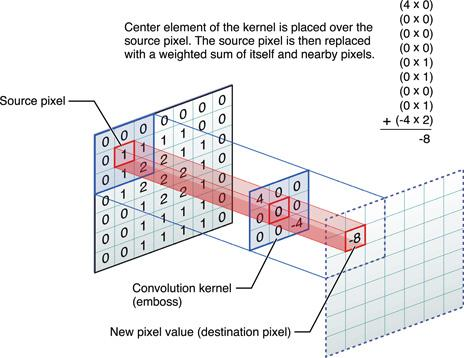

In [27]:
Image('pics/simple_convolution.jpg', width=750)

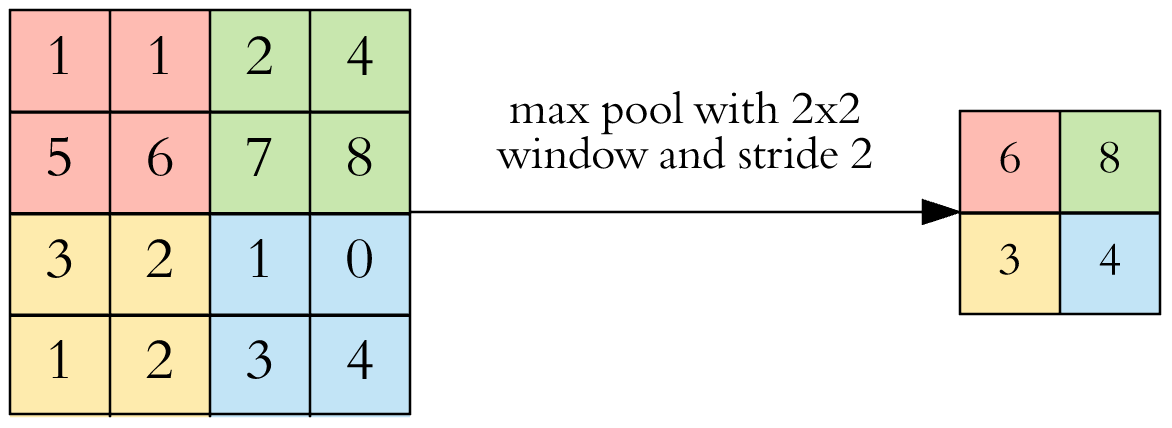

In [28]:
Image('pics/pooling.png', width=750)

In [29]:
model_dl = Sequential()

model_dl.add(Conv2D(filters=32,
                    kernel_size=(3, 3),
                    padding='same',
                    input_shape=x_train.shape[1:]))
model_dl.add(Activation('relu'))
model_dl.add(Conv2D(filters=32,
                    kernel_size=(3, 3)))
model_dl.add(Activation('relu'))
model_dl.add(MaxPooling2D(pool_size=(2, 2)))
model_dl.add(Dropout(0.25))

model_dl.add(Conv2D(filters=64,
                    kernel_size=(3, 3),
                    padding='same'))
model_dl.add(Activation('relu'))
model_dl.add(Conv2D(filters=64,
                    kernel_size=(3, 3)))
model_dl.add(Activation('relu'))
model_dl.add(MaxPooling2D(pool_size=(2, 2)))
model_dl.add(Dropout(0.25))

model_dl.add(Flatten())
model_dl.add(Dense(units=128))
model_dl.add(Activation('relu'))
model_dl.add(Dropout(0.5))
model_dl.add(Dense(units=10))
model_dl.add(Activation('softmax', name='out'))

In [30]:
model_dl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

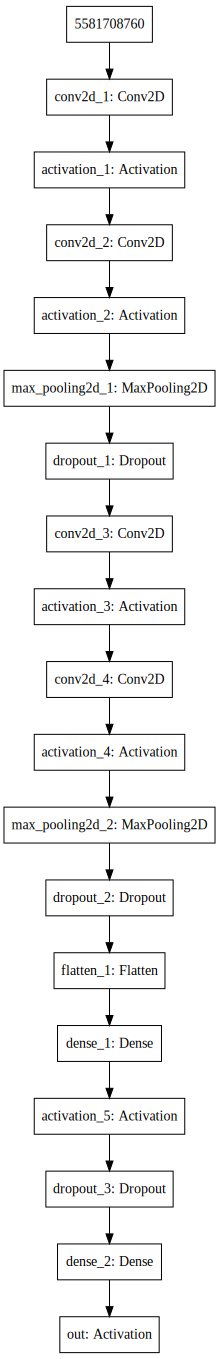

In [31]:
SVG(model_to_dot(model_dl).create(prog='dot', format='svg'))

In [32]:
opt = Adam(lr=0.0001)

model_dl.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics={'out': 'acc'})

In [34]:
history = model_dl.fit(
    x=x_train/255.,
    y=to_categorical(y_train, num_classes=10),
    batch_size=32,
    epochs=2,
    validation_data=(x_test/255., to_categorical(y_test, num_classes=10)),
    shuffle=True
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 254s 5ms/step - loss: 1.7441 - acc: 0.3604 - val_loss: 1.4981 - val_acc: 0.4636
Epoch 2/2
50000/50000 [==============================] - 251s 5ms/step - loss: 1.5435 - acc: 0.4398 - val_loss: 1.3717 - val_acc: 0.5125


In [35]:
preds_dl_train = model_dl.predict(x_train/255., verbose=1, batch_size=64)
preds_dl_test = model_dl.predict(x_test/255., verbose=1, batch_size=64)

10000/10000 [==============================] - 13s 1ms/step


### Оценим качество

In [36]:
print('CNN train accuracy')
print(accuracy_score(y_train.flatten(), np.argmax(preds_dl_train, axis=1)))
print('')
print('CNN test accuracy')
print(accuracy_score(y_test.flatten(), np.argmax(preds_dl_test, axis=1)))

CNN train accuracy
0.5148

CNN test accuracy
0.5125


### Посмотрим на динамику обучения

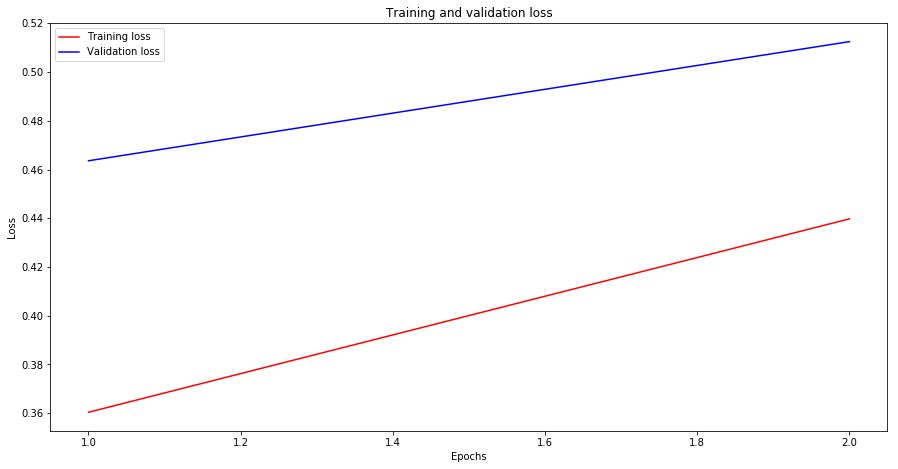

In [37]:
fig = plt.figure(figsize=(15,7.5))

epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['acc'], 'r', label='Training loss')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [39]:
history.history

{'val_loss': [1.4981085411071777, 1.371737159538269],
 'val_acc': [0.4636, 0.5125],
 'loss': [1.7441189604949952, 1.5435304448699951],
 'acc': [0.36038, 0.43976]}